In [24]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scroll bar when displaying Folium map
}

<IPython.core.display.Javascript object>

In [25]:
%pip install folium

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: dbapi 0.0.14 has a non-standard dependency specifier requests>. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of dbapi or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe - it's a wonderfully large dataset to play with! In particular, you will be asked to use data from the Ann Arbor Michigan location (my home!). and this is stored in the file: `assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:
* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write a python notebook which plots line graphs of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015. (Based on the graph, do you think extreme weather is getting more frequent in 2015?)
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

I've written some steps I think would be good to go through, but there are other ways to solve this assignment so feel free to explore the pandas library! What I really want to see is an image that looks like this sketch I drew at my desk:

![](assets/chris_sketch.png)

In [26]:
#  I'll be using the folium package to render the data into a map in Jupyter.

import folium
import pandas as pd

# get the location information for this dataset
df = pd.read_csv('assets/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
display(my_map)

## Step 1
Load the dataset and transform the data into Celsius (refer to documentation) then extract all of the rows which have minimum or maximum temperatures.

__hint: when I did this step I had two DataFrame objects, each with ~80,000 entries in it__

In [27]:
import pandas as pd
df = pd.read_csv('assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [28]:
# In this code cell, transform the Data_Value column
from datetime import datetime

date_format = "%Y-%m-%d"
df_max=df.where(df['Element'] == 'TMAX').dropna()
df_max['TMAX'] = df_max['Data_Value'].apply(lambda x: x/10)
df_max['Date'] = pd.to_datetime(df_max['Date'])
df_max['Leap'] =  df_max['Date'].dt.strftime('%d%m')

df_min=df.where(df['Element'] == 'TMIN').dropna()
df_min['TMIN'] = df_min['Data_Value'].apply(lambda x: x/10)
df_min['Date'] = pd.to_datetime(df_min['Date']) 
df_min['Leap'] =  df_min['Date'].dt.strftime('%d%m')


## Step 2
In order to visualize the data we would plot the min and max data for each day of the year between the years 2005 and 2014 across all weather stations. But we also need to find out when the min or max temperature in 2015 falls below the min or rises above the max for the previous decade.

If you did step 1 you have two Series objects with min and max times for the years 2005 through 2015. You can use Pandas `groupby` to create max and min temperature Series objects across all weather stations for each day of these years, and you can deal with the records for February 29 (the leap year) by dropping them.

__hint: when I finished this step, I had two DataFrame objects, each with exactly 4015 observations in them__

In [29]:
import numpy as np

In [30]:
# create a DataFrame of maximum temperature by date 
import numpy as np
df_max = df_max.where(df_max['Leap'] != "2902").dropna()
df_max = df_max.groupby(['Date']).agg({'TMAX': np.max})


# create a DataFrame of minimum temperatures by date
df_min = df_min.where(df_min['Leap'] != "2902").dropna()
df_min = df_min.groupby(['Date']).agg({'TMIN': np.min})

## Step 3
Now that you have grouped the daily max and min temperatures for each day of the years 2005 through 2015, you can separate out the data for 2015. Then you can use the Pandas `groupby` function to find the max and min of the temperature data for each __day of the year__ for the 2005-2014 data.

__hint: at the end of this step I had two DataFrames, one of maximum and the other of minimum values, which each had 365 observations in them. I also had another pair of similar DataFrames but only for the year 2015.__

In [31]:
# calculate the minimum and maximum values for the day of the year for 2005 through 2014
## poner un campo con el periodo que sea el día del año y calcular el máximo across días del año sin incluir 2015
meses = dict({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Ago', 9:'Set', 10:'Oct', 11:'Nov', 12:'Dec' })
df_max_05_14 = pd.DataFrame(df_max.loc['2005-01-01':'2014-12-31'])
df_max_05_14['yrday'] = df_max_05_14.index.strftime('%m-%d')
df_max_05_14['month'] = df_max_05_14.index.month
df_max_05_14['Fecha'] = df_max_05_14.index
df_max_05_14_agg = df_max_05_14.groupby(['yrday']).agg({'TMAX' : np.max, 'month' : np.median })

df_min_05_14 = pd.DataFrame(df_min.loc['2005-01-01':'2014-12-31'])
df_min_05_14['yrday'] = df_min_05_14.index.strftime('%m-%d')
df_min_05_14['month'] = df_min_05_14.index.month
df_min_05_14['Fecha'] = df_min_05_14.index
df_min_05_14_agg = df_min_05_14.groupby(['yrday']).agg({'TMIN' : np.min, 'month' : np.median})



# calculate the minimum and maximum values for the years 2015
df_max_15 = pd.DataFrame(df_max.loc['2015-01-01':'2015-12-31'])
df_max_15['yrday'] = df_max_15.index.strftime('%m-%d')
df_min_15 = pd.DataFrame(df_min.loc['2015-01-01':'2015-12-31'])
df_min_15['yrday'] = df_min_15.index.strftime('%m-%d')
#Comparar 
max_tresh = pd.DataFrame.merge(df_max_15, df_max_05_14_agg, how= 'inner', left_on='yrday', right_on='yrday' )#.where(['TMAX_x']>['TMAX_y'])
min_tresh = pd.DataFrame.merge(df_min_15, df_min_05_14_agg, how= 'inner', left_on='yrday', right_on='yrday' )#.where(['TMIN_x']<['TMIN_y'])
maximo = max_tresh.where(max_tresh['TMAX_x']>max_tresh['TMAX_y']).dropna()
minimo = min_tresh.where(min_tresh['TMIN_x']<min_tresh['TMIN_y']).dropna()
df_max_05_14_agg.reset_index(inplace=True)
df_max_05_14_agg['month'] = df_max_05_14_agg['month'].apply(lambda x: meses[x])
df_min_05_14_agg.reset_index(inplace=True)
df_min_05_14_agg['month'] = df_min_05_14_agg['month'].apply(lambda x: meses[x])
maximo.reset_index(inplace=True)
maximo['month'] = maximo['month'].apply(lambda x: meses[x])
minimo.reset_index(inplace=True)
minimo['month'] = minimo['month'].apply(lambda x: meses[x])

## Step 4
Now it's time to plot! You need to explore matplotlib in order to plot line graphs of the min and max temperatures for the years 2005 through 2014 and to scatter plot __only__ the daily 2015 temperatures that exceeded those values.

Text(0, -60, 'Range of temperatures per day of the year between the maximum and minimum (2005 -2014 data)\nversus the days in 2005 that are outside that range. There are 69 points. X-axis points in format MM-DD.\nSource GHCNd')

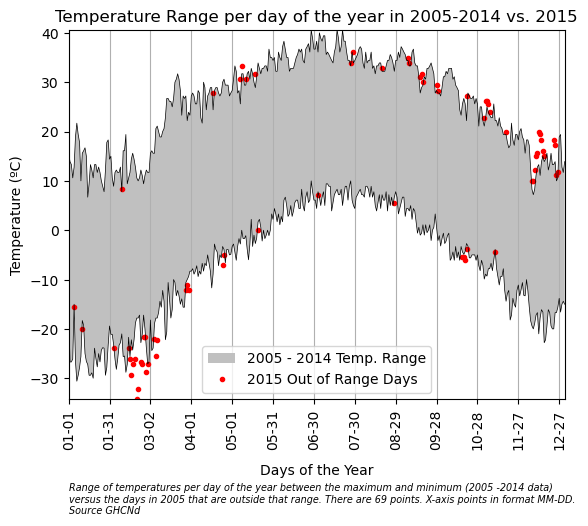

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from calendar import month_abbr

# put your plotting code here!
plt.xlabel('Days of the Year', labelpad = 10 )
plt.ylabel('Temperature (ºC)')

plt.title('Temperature Range per day of the year in 2005-2014 vs. 2015')

plt.gca().fill_between ( list(df_min_05_14_agg['yrday']), list(df_min_05_14_agg['TMIN']), list(df_max_05_14_agg['TMAX']), linestyle = ['-','-'], linewidths = [10,10], facecolor = 'silver'  )
plt.plot(list(maximo['yrday']),maximo['TMAX_x'], '.', color = 'red' )
plt.plot(list(minimo['yrday']),minimo['TMIN_x'], '.', color = 'red' )

plt.legend(['2005 - 2014 Temp. Range' , '2015 Out of Range Days'], loc = 'lower center' )
plt.plot(list(df_min_05_14_agg['TMIN']), '-', list(df_max_05_14_agg['TMAX']),'-' , linewidth=0.5, color = 'black')
ax = plt.gca()
plt.xticks(rotation = 'vertical')
plt.margins(0,0,tight=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.xaxis.grid(True)
plt.annotate('Range of temperatures per day of the year between the maximum and minimum (2005 -2014 data)\nversus the days in 2005 that are outside that range. There are 69 points. X-axis points in format MM-DD.\nSource GHCNd', (0,0), (0, -60), xycoords='axes fraction', textcoords='offset points', va='top', fontsize='x-small', fontstyle  = 'italic')